# Распаковка

In [356]:
%%capture
!rm -rf llm_opt optuna_results
!unzip Archive.zip
!rm -rf __MACOSX
!apt-get install tree

In [357]:
!tree llm_opt

llm_opt
├── etth1
│   ├── ETTh1-grid12_pred_len=168;th_b=8192;hypot.json
│   ├── ETTh1-grid12_pred_len=24;th_b=2048.json
│   ├── ETTh1-grid12_pred_len=24;th_b=8192;hypot.json
│   ├── ETTh1-grid12_pred_len=48;th_b=8192;hypot.json
│   ├── ETTh1-grid3_pred_len=168;th_b=8192;hypot.json
│   ├── ETTh1-grid3_pred_len=24;th_b=8192;hypot.json
│   └── ETTh1-grid3_pred_len=48;th_b=8192;hypot.json
└── etth2
    ├── ETTh2-grid12_pred_len=168;th_b=8192;hypot.json
    ├── ETTh2-grid12_pred_len=24;th_b=8192;hypot.json
    ├── ETTh2-grid12_pred_len=48;th_b=8192;hypot.json
    ├── ETTh2-grid3_pred_len=168;th_b=8192;hypot.json
    ├── ETTh2-grid3_pred_len=24;th_b=8192;hypot.json
    └── ETTh2-grid3_pred_len=48;th_b=8192;hypot.json

2 directories, 13 files


In [358]:
!tree optuna_results

optuna_results
├── etth1
│   ├── ETTh1;pred_len=168;OPTUNA.json
│   ├── ETTh1;pred_len=24;OPTUNA.json
│   └── ETTh1;pred_len=48;OPTUNA.json
└── etth2
    ├── ETTh2;pred_len=168;OPTUNA.json
    ├── ETTh2;pred_len=24;OPTUNA.json
    └── ETTh2;pred_len=48;OPTUNA.json

2 directories, 6 files


In [359]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def plot_comparison(name, grid):
    pred_lens = [24, 48, 168]
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    for ax, pl in zip(axes, pred_lens):
        optuna_f = f"optuna_results/{name.lower()}/{name};pred_len={pl};OPTUNA.json"
        grid_f = f"llm_opt/{name.lower()}/{name}-{grid}_pred_len={pl};th_b=8192;hypot.json"

        for f, lbl in [(optuna_f, "optuna"), (grid_f, grid)]:
            if Path(f).exists():
                df = pd.DataFrame(json.load(open(f, encoding='utf-8', errors='ignore')))
                df['trial'] = df['trial'] - df['trial'].min() + 1
                df = df[df['trial'] <= 35]
                ax.plot(df['trial'], df['mse_val'], label=lbl)

        ax.set_xlim(1, None)
        ax.set_title(f"pred_len={pl}")
        ax.legend()
        ax.set_xlabel("trial")
        ax.set_ylabel("mse_val")

    plt.suptitle(f"{name}: optuna vs {grid}")
    plt.tight_layout()
    plt.show()

def make_table(name, metric='test', score='mse'):
    pred_lens = [24, 48, 168]

    # Метрики из работы
    baseline = {
        'ETTh1': {24: {'mse': 0.098, 'mae': 0.247}, 48: {'mse': 0.158, 'mae': 0.319}, 168: {'mse': 0.183, 'mae': 0.346}},
        'ETTh2': {24: {'mse': 0.093, 'mae': 0.240}, 48: {'mse': 0.155, 'mae': 0.314}, 168: {'mse': 0.232, 'mae': 0.389}}
    }
    rows = []

    for pl in pred_lens:
        row = {'pred_len': pl}
        files = {
            'optuna': f"optuna_results/{name.lower()}/{name};pred_len={pl};OPTUNA.json",
            'grid12': f"llm_opt/{name.lower()}/{name}-grid12_pred_len={pl};th_b=8192;hypot.json",
            'grid3': f"llm_opt/{name.lower()}/{name}-grid3_pred_len={pl};th_b=8192;hypot.json"
        }

        for method, f in files.items():
            if Path(f).exists():
                df = pd.DataFrame(json.load(open(f, encoding='utf-8', errors='ignore')))
                best = df.loc[df['mse_val'].idxmin()]
                row[method] = best.get(f'{score}_{metric}', None)

        if metric == 'test':
            row['Paper'] = baseline[name][pl][score]
        rows.append(row)

    df_result = pd.DataFrame(rows).set_index('pred_len')

    def add_marker(row):
        winner = row.idxmin()
        return pd.Series({c: f"✅ {row[c]:.4f}" if c == winner else f"   {row[c]:.4f}" for c in row.index})

    return df_result.apply(add_marker, axis=1)


def make_table_worst(name, metric='test', score='mse'):
    pred_lens = [24, 48, 168]

    # Метрики из работы
    baseline = {
        'ETTh1': {24: {'mse': 0.098, 'mae': 0.247}, 48: {'mse': 0.158, 'mae': 0.319}, 168: {'mse': 0.183, 'mae': 0.346}},
        'ETTh2': {24: {'mse': 0.093, 'mae': 0.240}, 48: {'mse': 0.155, 'mae': 0.314}, 168: {'mse': 0.232, 'mae': 0.389}}
    }
    rows = []

    for pl in pred_lens:
        row = {'pred_len': pl}
        files = {
            'optuna': f"optuna_results/{name.lower()}/{name};pred_len={pl};OPTUNA.json",
            'grid12': f"llm_opt/{name.lower()}/{name}-grid12_pred_len={pl};th_b=8192;hypot.json",
            'grid3': f"llm_opt/{name.lower()}/{name}-grid3_pred_len={pl};th_b=8192;hypot.json"
        }

        for method, f in files.items():
            if Path(f).exists():
                df = pd.DataFrame(json.load(open(f, encoding='utf-8', errors='ignore')))
                worst = df.loc[df['mse_val'].idxmax()]
                row[method] = worst.get(f'{score}_{metric}', None)

        if metric == 'test':
            row['Paper'] = baseline[name][pl][score]
        rows.append(row)

    df_result = pd.DataFrame(rows).set_index('pred_len')

    def add_marker(row):
        loser = row.idxmax()
        return pd.Series({c: f"❌ {row[c]:.4f}" if c == loser else f"   {row[c]:.4f}" for c in row.index})

    return df_result.apply(add_marker, axis=1)

# Hypot vs base

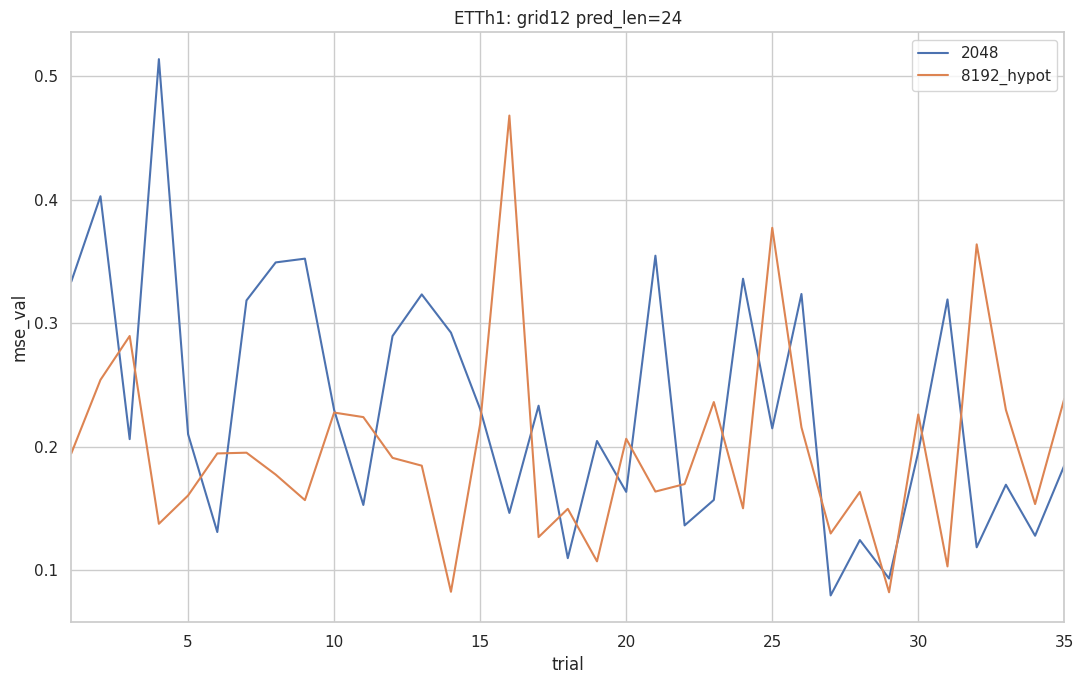

In [360]:
def plot_reasoning_comparison(name, pl):
    f_2048 = f"llm_opt/{name.lower()}/{name}-grid12_pred_len={pl};th_b=2048.json"
    f_8192 = f"llm_opt/{name.lower()}/{name}-grid12_pred_len={pl};th_b=8192;hypot.json"

    fig, ax = plt.subplots(figsize=(11, 7))

    for f, lbl in [(f_2048, "2048"), (f_8192, "8192_hypot")]:
        if Path(f).exists():
            df = pd.DataFrame(json.load(open(f, encoding='utf-8', errors='ignore')))
            df['trial'] = df['trial'] - df['trial'].min() + 1
            df = df[df['trial'] <= 35]
            ax.plot(df['trial'], df['mse_val'], label=lbl)

    ax.set_xlim(1, 35)
    ax.set_title(f"{name}: grid12 pred_len={pl}")
    ax.legend()
    ax.set_xlabel("trial")
    ax.set_ylabel("mse_val")
    plt.tight_layout()
    plt.show()

plot_reasoning_comparison('ETTh1', 24)

# ETTh1

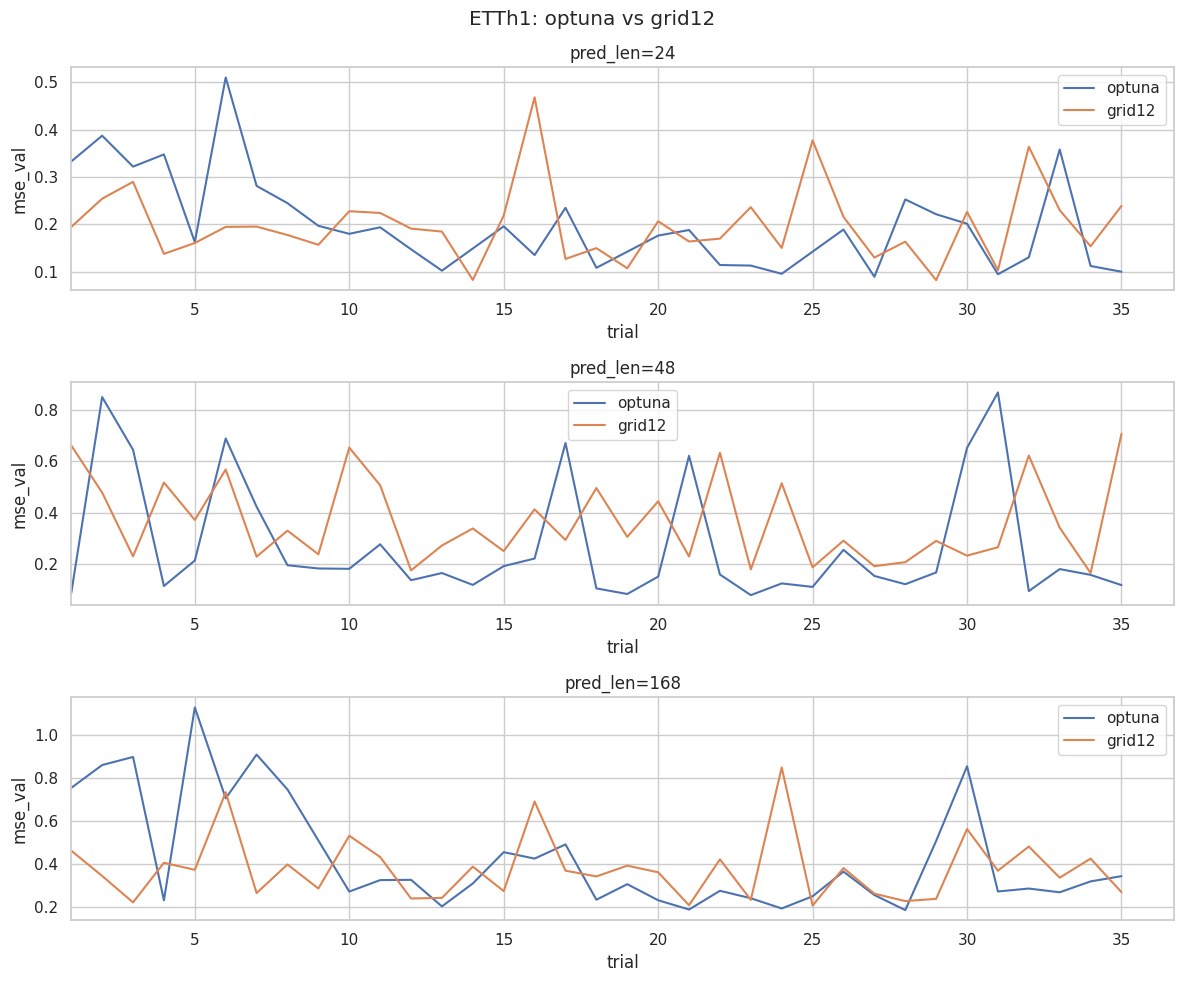

In [361]:
plot_comparison('ETTh1', 'grid12')

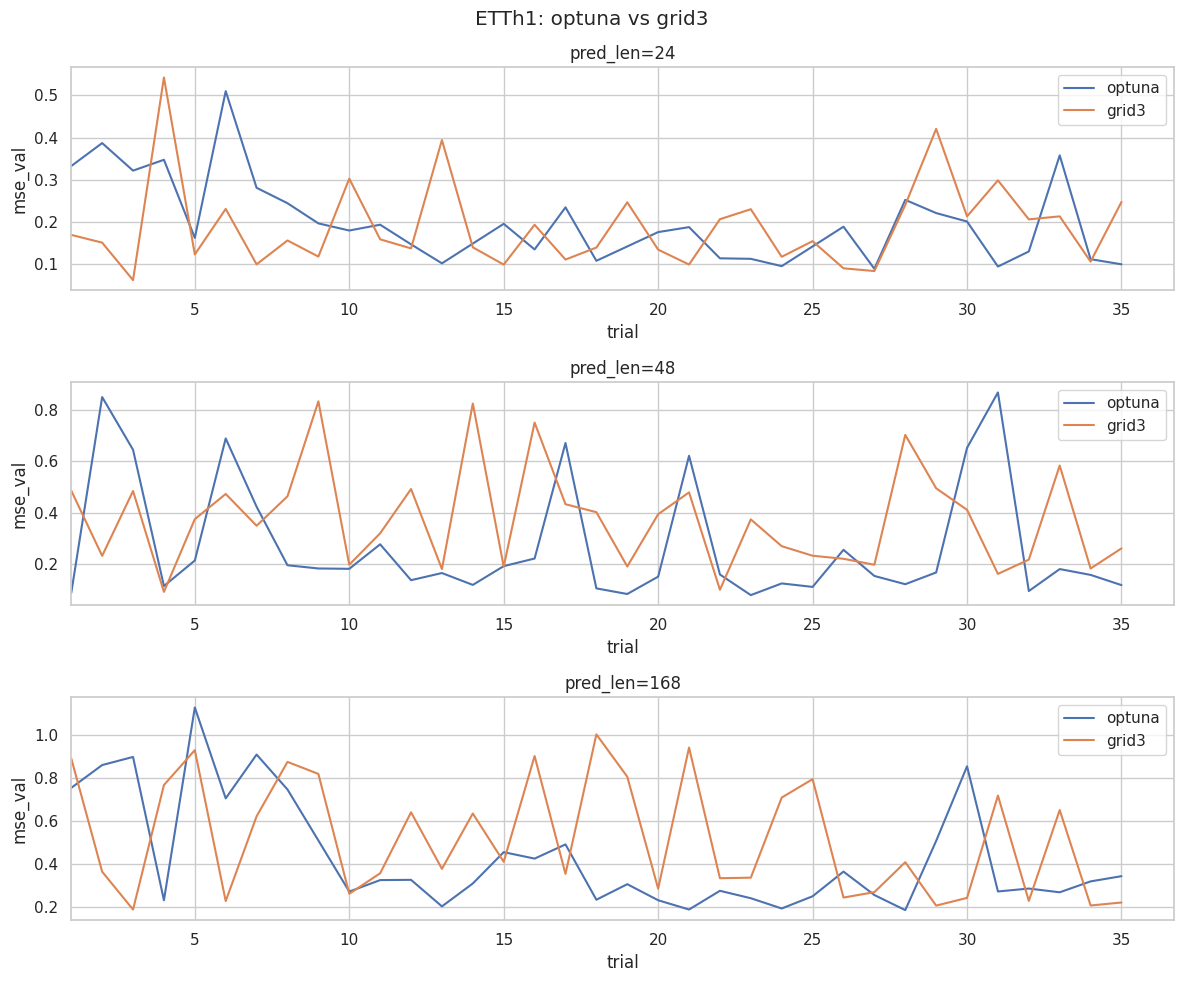

In [362]:
plot_comparison('ETTh1', 'grid3')

In [363]:
dataset_name = 'ETTh1'

In [364]:
make_table(dataset_name, 'test', 'mse')

,optuna,grid12,grid3,Paper
pred_len,,,,
24,0.1147,0.0891,✅ 0.0635,0.0980
48,✅ 0.1351,0.1897,0.1398,0.1580
168,✅ 0.1281,0.1615,0.1740,0.1830


In [365]:
make_table(dataset_name, 'val', 'mse')

,optuna,grid12,grid3
pred_len,,,
24,0.0894,0.0824,✅ 0.0626
48,✅ 0.0799,0.1657,0.0925
168,✅ 0.1837,0.2049,0.1863


In [366]:
make_table(dataset_name, 'test', 'mae')

,optuna,grid12,grid3,Paper
pred_len,,,,
24,0.2643,0.2320,✅ 0.1996,0.2470
48,✅ 0.2942,0.3524,0.3041,0.3190
168,✅ 0.2931,0.3222,0.3331,0.3460


In [367]:
make_table(dataset_name, 'val', 'mae')

,optuna,grid12,grid3
pred_len,,,
24,0.2300,0.2170,✅ 0.1932
48,✅ 0.2218,0.3183,0.2306
168,✅ 0.3356,0.3529,0.3432


# ETTh2

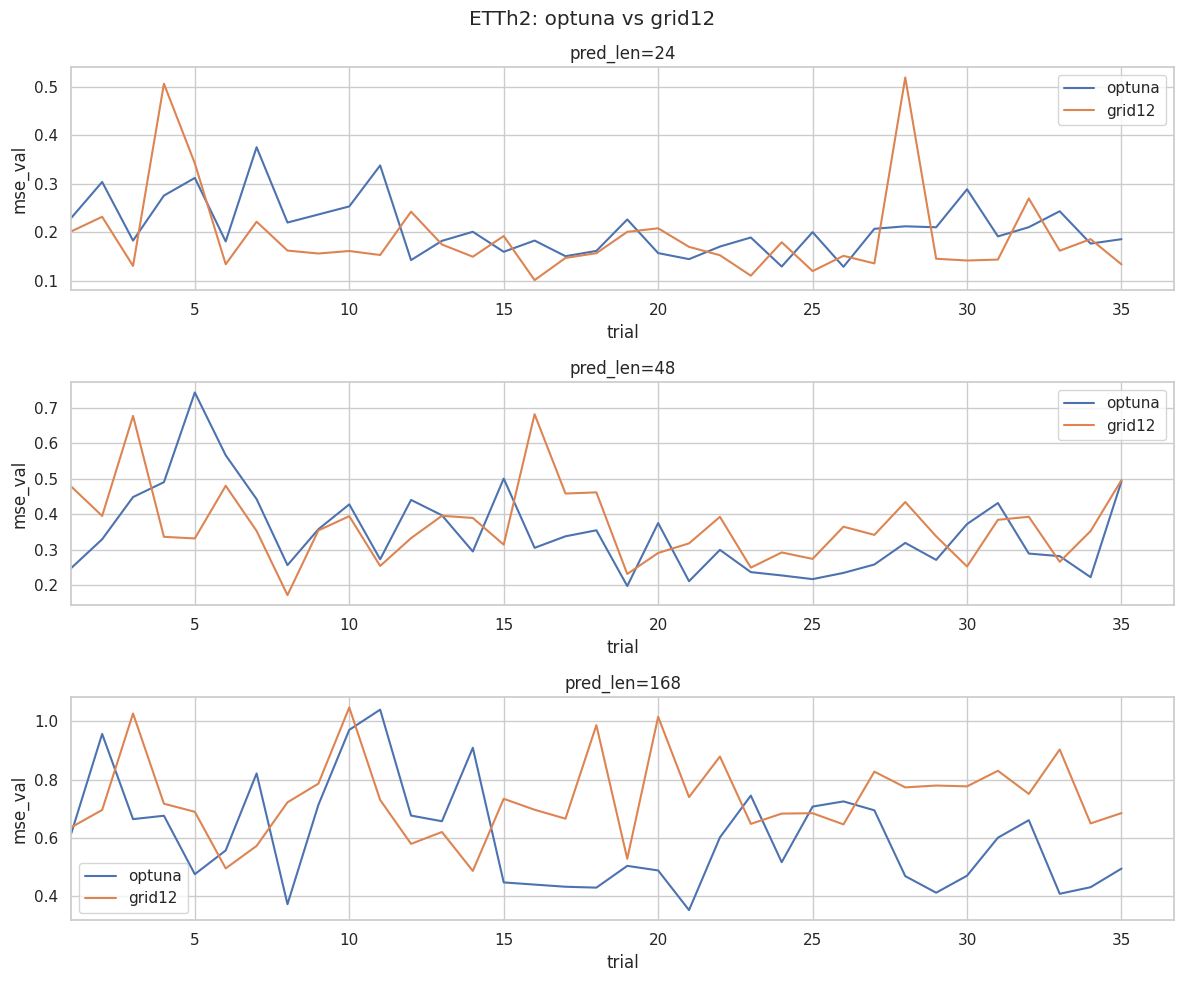

In [368]:
plot_comparison('ETTh2', 'grid12')

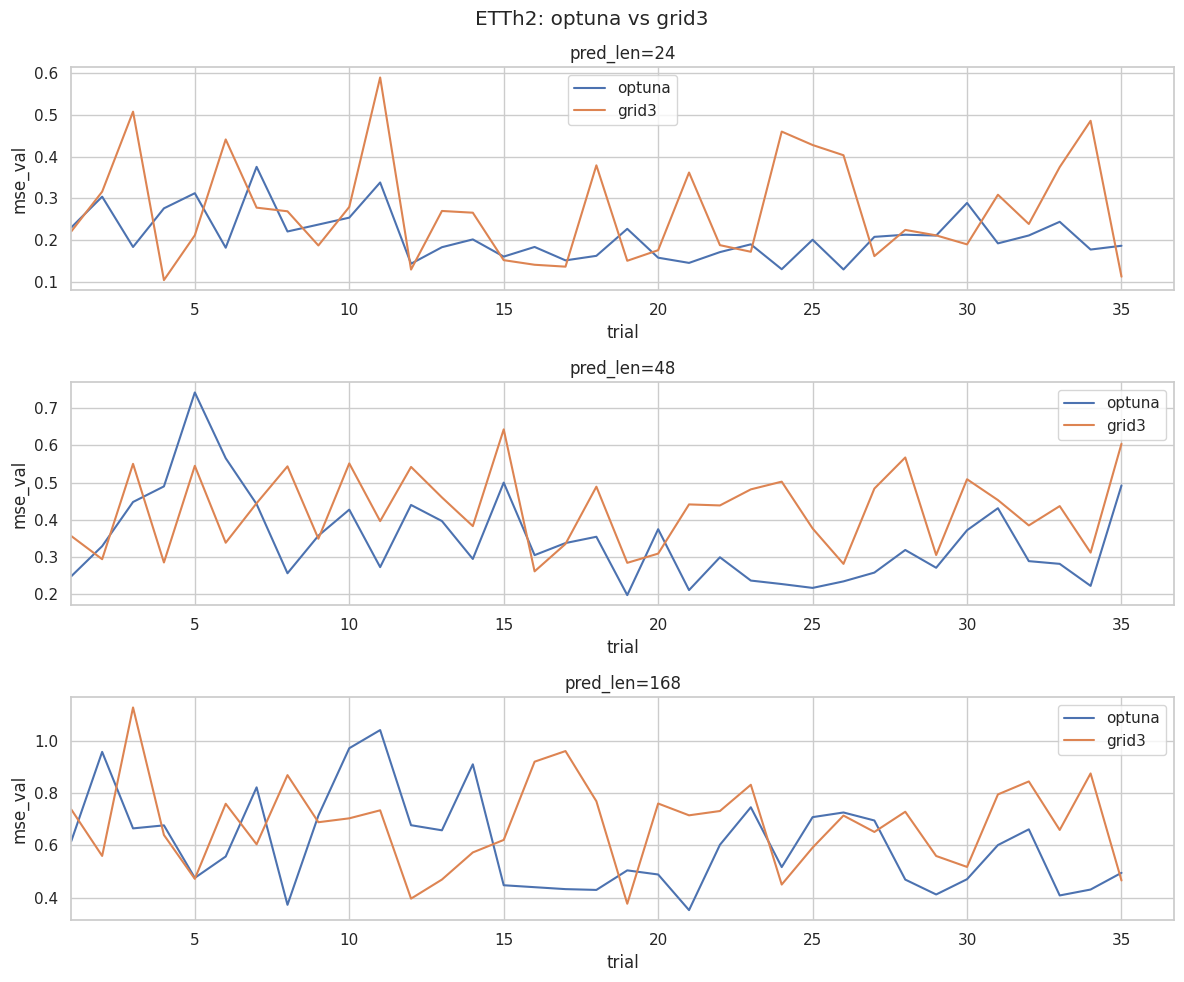

In [369]:
plot_comparison('ETTh2', 'grid3')

In [370]:
dataset_name = 'ETTh2'

In [371]:
make_table(dataset_name, 'test', 'mse')

,optuna,grid12,grid3,Paper
pred_len,,,,
24,0.2117,0.1431,0.1788,✅ 0.0930
48,0.2905,0.2295,0.3443,✅ 0.1550
168,0.3889,0.3948,0.4743,✅ 0.2320


In [372]:
make_table(dataset_name, 'val', 'mse')

,optuna,grid12,grid3
pred_len,,,
24,0.1295,✅ 0.1021,0.1039
48,0.1976,✅ 0.1719,0.2615
168,✅ 0.3533,0.4877,0.3776


In [373]:
make_table(dataset_name, 'test', 'mae')

,optuna,grid12,grid3,Paper
pred_len,,,,
24,0.3568,0.2703,0.3082,✅ 0.2400
48,0.4294,0.3727,0.4799,✅ 0.3140
168,0.5097,0.5230,0.5525,✅ 0.3890


In [374]:
make_table(dataset_name, 'val', 'mae')

,optuna,grid12,grid3
pred_len,,,
24,0.2933,✅ 0.2532,0.2550
48,0.3535,✅ 0.3362,0.4140
168,✅ 0.4853,0.5775,0.4951
